<a href="https://colab.research.google.com/github/zahrasa/Sentiment-Analysis-of-imdb-movie-reviews/blob/main/svm_rbf_kernel_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import metrics

download dataset

In [2]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Download the dataset
! rm -rf * 
! gdown 1M2BZan7tAbefEQXo3Yy5SUrGDpdedhcW

Downloading...
From: https://drive.google.com/uc?id=1M2BZan7tAbefEQXo3Yy5SUrGDpdedhcW
To: /content/imdb_movie_reviews.zip
100% 26.9M/26.9M [00:00<00:00, 119MB/s] 


In [4]:
! unzip "imdb_movie_reviews.zip"
! rm -r "imdb_movie_reviews.zip"

Archive:  imdb_movie_reviews.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: Valid.csv               


import training, valid and test data

In [5]:
imdb_data_train = pd.read_csv("Train.csv")
train_reviews = imdb_data_train.text[:]
train_sentiments = imdb_data_train.label[:]

imdb_data_valid = pd.read_csv("Valid.csv")
valid_reviews = imdb_data_valid.text[:]
valid_sentiments = imdb_data_valid.label[:]

imdb_data_test = pd.read_csv("Test.csv")
test_reviews = imdb_data_test.text[:]
test_sentiments = imdb_data_test.label[:]

#label count
print("number of texts and labels in train set:")
print(train_reviews.shape, train_sentiments.shape)
print("number of texts and labels in valid set:")
print(valid_reviews.shape, valid_sentiments.shape)
print("number of texts and labels in test set:")
print(test_reviews.shape, test_sentiments.shape)
print("\n")
print("number of 0s and 1s labels in train set:")
print(imdb_data_train['label'].value_counts())
print("number of 0s and 1s are somewhat equal. So data train set is balanced.\n\n")


number of texts and labels in train set:
(40000,) (40000,)
number of texts and labels in valid set:
(5000,) (5000,)
number of texts and labels in test set:
(5000,) (5000,)


number of 0s and 1s labels in train set:
0    20019
1    19981
Name: label, dtype: int64
number of 0s and 1s are somewhat equal. So data train set is balanced.




In [6]:
print("5 first train set:")
imdb_data_train.head()

5 first train set:


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [7]:
print("5 first valid set:")
imdb_data_valid.head()

5 first valid set:


,text,label
0,It's been about 14 years since Sharon Stone aw...,0
1,someone needed to make a car payment... this i...,0
2,The Guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,0


In [8]:
print("5 first test set:")
imdb_data_test.head()

5 first test set:


,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


transformed label data

In [9]:
#labeling the sentient data
lb = LabelBinarizer()
#transformed sentiment data
sentiment_data_train = lb.fit_transform(imdb_data_train['label'])
sentiment_data_valid = lb.fit_transform(imdb_data_valid['label'])
sentiment_data_test = lb.fit_transform(imdb_data_test['label'])
print(sentiment_data_train.shape)
print(sentiment_data_valid.shape)
print(sentiment_data_test.shape)


#Spliting the sentiment data
train_sentiments = sentiment_data_train[:]
valid_sentiments = sentiment_data_valid[:]
test_sentiments = sentiment_data_test[:]
print(train_sentiments)

(40000, 1)
(5000, 1)
(5000, 1)
[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]


starting preprocessing
Tokenization of text

In [10]:
tokenizer = ToktokTokenizer()
#Setting English stopwords
import nltk
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Removing the html strips

In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(strip_html)
imdb_data_valid['text'] = imdb_data_valid['text'].apply(strip_html)
imdb_data_test['text'] = imdb_data_test['text'].apply(strip_html)

print(imdb_data_train.head(5))
print(imdb_data_valid.head(5))
print(imdb_data_test.head(5))

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
                                                text  label
0  It's been about 14 years since Sharon Stone aw...      0
1  someone needed to make a car payment... this i...      0
2  The Guidelines state that a comment must conta...      0
3  This movie is a muddled mish-mash of clichés f...      0
4  Before Stan Laurel became the smaller half of ...      0
                                                text  label
0  I always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0
2  This movie was so poorly written and directed ...      0
3  The most interesting thing about Miry

Removing the square brackets

In [12]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(remove_between_square_brackets)
imdb_data_valid['text'] = imdb_data_valid['text'].apply(remove_between_square_brackets)
imdb_data_test['text'] = imdb_data_test['text'].apply(remove_between_square_brackets)

print(imdb_data_train.head(5))
print(imdb_data_valid.head(5))
print(imdb_data_test.head(5))

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
                                                text  label
0  It's been about 14 years since Sharon Stone aw...      0
1  someone needed to make a car payment... this i...      0
2  The Guidelines state that a comment must conta...      0
3  This movie is a muddled mish-mash of clichés f...      0
4  Before Stan Laurel became the smaller half of ...      0
                                                text  label
0  I always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0
2  This movie was so poorly written and directed ...      0
3  The most interesting thing about Miry

Removing the stopwords in text

In [13]:
#set stopwords to english
stop = set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(remove_stopwords)
imdb_data_valid['text'] = imdb_data_valid['text'].apply(remove_stopwords)
imdb_data_test['text'] = imdb_data_test['text'].apply(remove_stopwords)

print(imdb_data_train.head(5))
print(imdb_data_valid.head(5))
print(imdb_data_test.head(5))

{'when', 'y', "she's", 'until', 'can', 'needn', 'these', "it's", 'had', 'will', 'hasn', 'too', 'as', 'don', 'has', 'other', 'the', 'just', 'most', 'because', 'them', 'on', 'him', 'further', 'a', 'what', 'she', 'have', 'to', "isn't", "needn't", "don't", "aren't", 'above', 'are', "weren't", 'who', 'or', 'how', 'while', 'doesn', "mustn't", "won't", 'very', "doesn't", 'you', 'be', 'shouldn', 'am', 'ma', 'all', 'after', 'your', 'whom', 'should', 'mustn', 'own', "didn't", 'ours', "mightn't", 'aren', "hadn't", 'll', "hasn't", 'more', 'd', 'weren', 'any', "should've", 'this', 't', 'for', 'they', 'those', 'does', 'that', 'at', 'few', 'before', 'below', 'her', "shan't", 'wouldn', 'which', 'but', 'an', 'such', "you'd", 'itself', 'then', "couldn't", 'same', 'in', 'himself', 'hers', 'having', 've', 'during', 'over', 'through', 'being', 'so', 'yourselves', 'some', "wouldn't", 'mightn', 'both', 'it', 'me', 'theirs', 'into', 'didn', 'o', 'if', "haven't", 'against', 'haven', 'been', 'out', 'm', 'hadn',

Define function for removing special characters

In [14]:
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(remove_special_characters)
imdb_data_valid['text'] = imdb_data_valid['text'].apply(remove_special_characters)
imdb_data_test['text'] = imdb_data_test['text'].apply(remove_special_characters)

print(imdb_data_train.head(5))
print(imdb_data_valid.head(5))
print(imdb_data_test.head(5))

                                                text  label
0  grew  b 1965  watching loving Thunderbirds mat...      0
1  put movie DVD player  sat coke chips  expectat...      0
2  people know particular time past like feel nee...      0
3  Even though great interest Biblical movies  bo...      0
4  Im die hard Dads Army fan nothing ever change ...      1
                                                text  label
0   14 years since Sharon Stone awarded viewers l...      0
1  someone needed make car payment  truly awful  ...      0
2  Guidelines state comment must contain minimum ...      0
3  movie muddled mishmash clichs recent cinema pr...      0
4  Stan Laurel became smaller half alltime greate...      0
                                                text  label
0  always wrote series complete stinkfest Jim Bel...      0
1  1st watched 1272002  3 10 DirSteve Purcell   T...      0
2  movie poorly written directed fell asleep 30 m...      0
3  interesting thing Miryang  Secret Sun

Stemming the text

In [15]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb_data_train['text'] = imdb_data_train['text'].apply(simple_stemmer)
imdb_data_valid['text'] = imdb_data_valid['text'].apply(simple_stemmer)
imdb_data_test['text'] = imdb_data_test['text'].apply(simple_stemmer)

print(imdb_data_train.head(5))
print(imdb_data_valid.head(5))
print(imdb_data_test.head(5))

                                                text  label
0  grew b 1965 watch love thunderbird mate school...      0
1  put movi dvd player sat coke chip expect hope ...      0
2  peopl know particular time past like feel need...      0
3  even though great interest biblic movi bore de...      0
4  im die hard dad armi fan noth ever chang that ...      1
                                                text  label
0  14 year sinc sharon stone award viewer legcros...      0
1  someon need make car payment truli aw make jea...      0
2  guidelin state comment must contain minimum fo...      0
3  movi muddl mishmash clich recent cinema promis...      0
4  stan laurel becam smaller half alltim greatest...      0
                                                text  label
0  alway wrote seri complet stinkfest jim belushi...      0
1  1st watch 1272002 3 10 dirstev purcel typic ma...      0
2  movi poorli written direct fell asleep 30 minu...      0
3  interest thing miryang secret sunshin

Remove Low Frequency Words of data sets

In [16]:
freq_train = pd.Series(' '.join(imdb_data_train['text']).split()).value_counts()
less_five_freq_train = freq_train[(freq_train <5)]
print(less_five_freq_train)

freq_valid = pd.Series(' '.join(imdb_data_valid['text']).split()).value_counts()
less_five_freq_valid = freq_valid[(freq_valid <5)]
print(less_five_freq_valid)

freq_test = pd.Series(' '.join(imdb_data_test['text']).split()).value_counts()
less_five_freq_test = freq_test[(freq_test <5)]
print(less_five_freq_test)

imdb_data_train['text'] = imdb_data_train['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_train))
imdb_data_valid['text'] = imdb_data_valid['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_valid))
imdb_data_test['text'] = imdb_data_test['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in less_five_freq_test))

startth           4
postlethwait      4
kopolski          4
crystallin        4
fizzi             4
                 ..
himselfconsequ    1
janether          1
saysth            1
exroomm           1
me810             1
Length: 105841, dtype: int64
himesh          4
sanctimoni      4
willett         4
occult          4
fork            4
               ..
geezerrock      1
ozzfest         1
sevnti          1
superpos        1
psychodramat    1
Length: 28398, dtype: int64
dissuad      4
burnt        4
callou       4
castro       4
sleepless    4
            ..
halldavi     1
lilian       1
accenty      1
corbi        1
vilnach      1
Length: 28197, dtype: int64


normalizing

In [17]:
#normalized train reviews
norm_train_reviews = imdb_data_train.text[:]
print(norm_train_reviews.head(5))

#Normalized valid reviews
norm_valid_reviews = imdb_data_valid.text[:]
print(norm_valid_reviews.head(5))

#Normalized test reviews
norm_test_reviews = imdb_data_test.text[:]
print(norm_test_reviews.head(5))

0    grew b 1965 watch love thunderbird mate school...
1    put movi dvd player sat coke chip expect hope ...
2    peopl know particular time past like feel need...
3    even though great interest biblic movi bore de...
4    im die hard dad armi fan noth ever chang that ...
Name: text, dtype: object
0    14 year sinc sharon stone award viewer twist m...
1    someon need make car payment truli aw make jea...
2    state comment must contain minimum four line r...
3    movi muddl mishmash clich recent cinema promis...
4    stan laurel becam smaller half alltim greatest...
Name: text, dtype: object
0    alway wrote seri complet jim belushi involv he...
1    1st watch 3 10 typic mari kate amp ashley fare...
2    movi poorli written direct fell asleep 30 minu...
3    interest thing secret sunshin actor lee shina ...
4    first read berlin expect much thought right pe...
Name: text, dtype: object


TF IDF feature vector

In [18]:
# Count vectorizer for TFIDF

tv = TfidfVectorizer()

# transformed train reviews
tv_train_reviews = tv.fit_transform(norm_train_reviews)

# transformed test reviews
tv_test_reviews = tv.transform(norm_test_reviews)

# transformed test reviews
tv_valid_reviews = tv.transform(norm_valid_reviews)

print('Tfidf_train:', tv_train_reviews.shape)
print('Tfidf_test:', tv_test_reviews.shape)
print('Tfidf_test:', tv_valid_reviews.shape)

Tfidf_train: (40000, 27127)
Tfidf_test: (5000, 27127)
Tfidf_test: (5000, 27127)


grid search and find c and gamma

In [19]:
#create a dictionary of possible parameters
params_grid = {'C':[0.1, 1, 10],'gamma':[0.01, 0.1, 1],}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), params_grid)

#fitting with the best posible object
clf = clf.fit(tv_valid_reviews,valid_sentiments.ravel())
print(clf.best_estimator_)

SVC(C=10, class_weight='balanced', gamma=1)


training AND predictng the svm model with TFIDF

In [20]:
# Predicting the model for tfidf features
svm_tfidf_predict = clf.predict(tv_test_reviews)

ROC

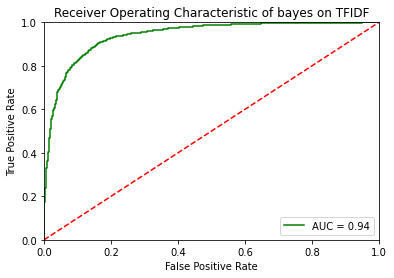

In [21]:
# ROC
probs_tfidf = clf.decision_function(tv_test_reviews)
preds_tfidf = probs_tfidf
fpr_tfidf , tpr_tfidf , threshold_tfidf = metrics.roc_curve(test_sentiments,preds_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)

plt.title('Receiver Operating Characteristic of bayes on TFIDF')
plt.plot(fpr_tfidf, tpr_tfidf, 'b', label='AUC = %0.2f' % roc_auc_tfidf , color='green')
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy

In [22]:
# Accuracy score for bag of words
svm_tfidf_score = accuracy_score(test_sentiments,svm_tfidf_predict)
print("svm_tfidf_score :", svm_tfidf_score)

svm_tfidf_score : 0.8688


Classification report

In [23]:
# Classification report for bag of words
svm_tfidf_report = classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.88      0.85      0.87      2495
    Negative       0.85      0.89      0.87      2505

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



Compute Area Under the Curve (AUC):

In [24]:
fpr_tfidf, tpr_tfidf, thresholds_cfidf = metrics.roc_curve(test_sentiments, svm_tfidf_predict)
auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
print("AUC tfidf:", auc_tfidf)

AUC tfidf: 0.8687586750347001


confusion matrix

In [25]:
# confusion matrix for bag of words
cm_tfidf = confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[2228  277]
 [ 379 2116]]


word cloud for positive review words

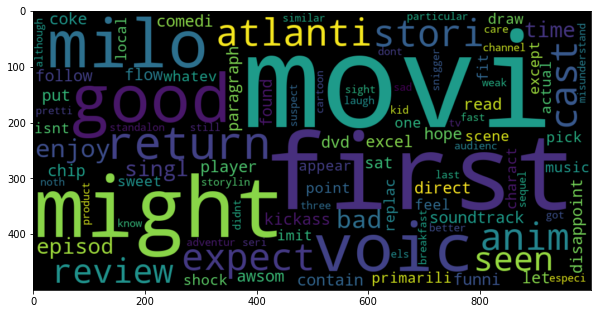

In [26]:
plt.figure(figsize=(10,10))
positive_text = norm_train_reviews[1]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show()

word cloud for negative review words

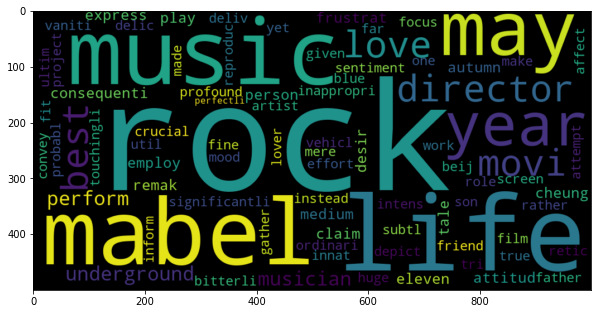

In [27]:
plt.figure(figsize=(10,10))
negative_text = norm_train_reviews[8]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
negative_words = WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show()